# Лабораторная работа №3. Однофакторный дисперсионный анализ

> Вариант № ??

**Распределения**:

$X_1$ ~ ?? (объём выборки $n_1$ &mdash; ?)

$X_2$ ~ ?? (объём выборки $n_2$ &mdash; ?)

$X_3$ ~ ?? (объём выборки $n_3$ &mdash; ?)

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Немного магии для того, чтобы рисунки стали больше
import pylab
pylab.rcParams['figure.figsize'] = (24.0, 16.0)
plt.rcParams.update({'font.size': 22})

# Вспомогательные классы и функции, определённые тут же (см. репозиторий)
# https://github.com/BobNobrain/matstat-labs/tree/master/s
from s import Sample, PooledSample, BartlettHyp, OneWayAnovaHyp, LinearContrastHyp
from s.utils import table, printf

## 1. Исходные данные

In [2]:
X1 = stats.chi2(15)
X2 = stats.uniform(5, 20)
X3 = stats.norm(5, 2)

n1 = 50
n2 = 100
n3 = 100

print('Характеристики наблюдаемых случайных величин:')
table(
    ['СВ', 'Распределение', 'Параметры', '$m_i$', '$\\sigma_i^2$', '$n_i$'],
    [
        ['X1', '$X^2$', '$k=15$', X1.mean(), X1.var(), n1],
        ['X2', 'R', '$a=5, b=25$', X2.mean(), X2.var(), n2],
        ['X3', 'N', '$m=5, \\sigma=2$', X3.mean(), X3.var(), n3]
    ]
)
printf('Количество случайных величин $k={}$', 3)
    

Характеристики наблюдаемых случайных величин:


СВ,Распределение,Параметры,$m_i$,$\sigma_i^2$,$n_i$
X1,$X^2$,$k=15$,15.0,30.0,50
X2,R,"$a=5, b=25$",15.0,33.33333333333333,100
X3,N,"$m=5, \sigma=2$",5.0,4.0,100


In [3]:
x1 = Sample.from_distribution("x1", X1, count=n1)
x2 = Sample.from_distribution("x2", X2, count=n2)
x3 = Sample.from_distribution("x3", X3, count=n3)

x_pooled = PooledSample("Pooled", x1, x2, x3)

print('Выборочные характеристики:')
table(
    ['СВ', 'Среднее $\\overline{x_i}$', '$s^2_i$', '$s_i$'],
    [
        [
            s._name,
            round(s.mean(), 4),
            round(s.s() ** 2, 4),
            round(s.s(), 4)
        ] for s in [x1, x2, x3, x_pooled]
    ]
)

Выборочные характеристики:


СВ,Среднее $\overline{x_i}$,$s^2_i$,$s_i$
x1,13.1693,21.7786,4.6668
x2,14.5819,29.3772,5.4201
x3,5.2376,3.6058,1.8989
Pooled,10.5617,36.6397,6.0531


## 2. Визуальное представление выборок

Диаграммы *Box-and-Whisker*:

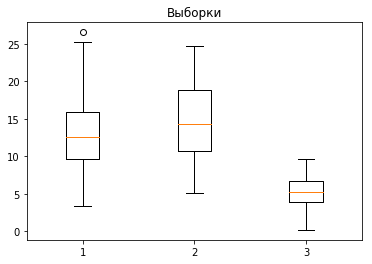

In [4]:
fig, ax = plt.subplots()

ax.boxplot([x1.data(), x2.data(), x3.data()])
ax.set_title('Выборки')

plt.show()

## 3. Проверка условия применимости дисперсионного анализа

Статистическая гипотеза $H_0: \sigma_1^2 = \sigma_2^2 = \sigma_3^2$

In [5]:
print('Критерий Бартлетта')

alpha = 0.05

H0 = BartlettHyp(x_pooled)
criterion_value, interval, p_value, result = H0.full_test(x_pooled, alpha)

table(
    [
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha={}$'.format(alpha),
        'Ошибка статистического решения'
    ],
    [[
        round(criterion_value, 4),
        round(p_value, 4),
        'H0' if result else 'H1',
        'TODO'
    ]]
)

Критерий Бартлетта


Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha=0.05$,Ошибка статистического решения
94.378,0.0,H1,TODO


## 4. Однофакторный дисперсионный анализ

In [6]:
print('Таблица дисперсионного анализа')

D_between = x_pooled.between_group_var()
D_within = x_pooled.within_group_var()
D_x = x_pooled.var()
n = x_pooled.n()
k = x_pooled.num_groups()

# http://datalearning.ru/index.php/textbook?cid=1&mid=5&topic=2, таблица 6.4
table(
    ['Источник вариации', 'Показатель вариации', 'Число степеней свободы', 'Несмещённая оценка'],
    [
        ['Группировочный признак', round(D_between, 4), k - 1, round(n * D_between/ (k - 1), 4)],
        ['Остаточные признаки', round(D_within, 4), n - k, round(n * D_within/ (n - k), 4)],
        ['Все признаки', round(D_x, 4), n - 1, round(n * D_x/ (n - 1), 4)]
    ]
)

eta2 = x_pooled.eta_squared()
printf('Эмпирический коэффициент детерминации $\\eta^2 = {}$', round(eta2, 4))
printf('Эмпирическое корреляционное отношение $\\eta = {}$', round(np.sqrt(eta2), 4))

Таблица дисперсионного анализа


Источник вариации,Показатель вариации,Число степеней свободы,Несмещённая оценка
Группировочный признак,19.1633,2,2395.4107
Остаточные признаки,17.3299,247,17.5404
Все признаки,36.4932,249,36.6397


Статистическая гипотеза $H_0: m_1 = m_2 = m_3$

In [7]:
alpha = 0.05

anova = OneWayAnovaHyp(x_pooled)
criterion_value, (crit_left, crit_right), p_value, result = anova.full_test(x_pooled, alpha)

table(
    [
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha={}$'.format(alpha),
        'Ошибка статистического решения'
    ],
    [[
        round(criterion_value, 4),
        round(p_value, 4),
        'H0' if result else 'H1',
        'TODO'
    ]]
)


Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha=0.05$,Ошибка статистического решения
136.5656,0.0,H1,TODO


## 5. Метод линейных контрастов

In [8]:
def get_line(H0, coeffs, alpha=alpha):
    c, (c_1, c_2), p_value, result = H0.full_test(coeffs, alpha)
    print(c_1, c_2)
    return round(c, 4), round(p_value, 4), '$=$' if result else '$\\ne$', 'TODO'

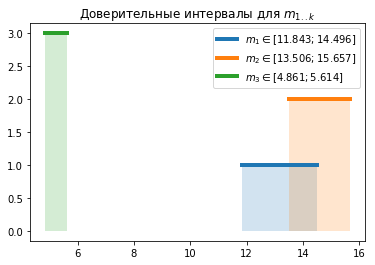

-3.1990269514994485 0.37382863061914096
7.8857228996552164 10.802947266603585
6.145308131629953 9.718163713748542


Гипотеза,Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha=0.05$,Ошибка статистического решения
$m_1=m_2$,-1.4126,0.0,$=$,TODO
$m_2=m_3$,9.3443,0.0002,$\ne$,TODO
$m_1=m_3$,7.9317,0.0009,$\ne$,TODO


In [9]:
alpha = 0.05

def m_interval(sample):
    n = sample.n()
    delta = stats.t(n - 1).ppf(1 - alpha / 2) * sample.s() / np.sqrt(n)
    mean = sample.mean()
    return mean - delta, mean + delta
    
fig, ax = plt.subplots()
ax.set_title('Доверительные интервалы для $m_{1..k}$')

samples = [x1, x2, x3]
for i in range(len(samples)):
    l, r = m_interval(samples[i])
    domain = [l, r]
    values = [i + 1, i + 1]
    ax.plot(
        domain,
        values,
        label='$m_{} \\in [{}; {}]$'.format(i + 1, round(l, 3), round(r, 3)),
        linewidth=4
    )
    ax.fill_between(domain, 0, values, alpha=.2)

plt.legend()
plt.show()

# TODO: вынести в функцию и сделать для всех комбинаций
H0 = LinearContrastHyp(x_pooled)
c, (c_1, c_2), p_value, result = H0.full_test([1, -1, 0], alpha=alpha)

table(
    [
        'Гипотеза',
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha={}$'.format(alpha),
        'Ошибка статистического решения'
    ],
    [
        ['$m_1=m_2$', *get_line(H0, [1, -1, 0], alpha)],
        ['$m_2=m_3$', *get_line(H0, [0, 1, -1], alpha)],
        ['$m_1=m_3$', *get_line(H0, [1, 0, -1], alpha)]
    ]
)